<a href="https://colab.research.google.com/github/josh-truong/california-housing-kmeans/blob/main/california_housing_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

In [ ]:
df = pd.read_csv("/content/sample_data/california_housing_train.csv")
n_features = df.shape[1]
print(len(df))
df.head(5)

17000


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


(array([1833., 6100., 5020., 2466.,  891.,  368.,  152.,   79.,   42.,
          49.]),
 array([ 0.4999 ,  1.94992,  3.39994,  4.84996,  6.29998,  7.75   ,
         9.20002, 10.65004, 12.10006, 13.55008, 15.0001 ]),
 <a list of 10 Patch objects>)

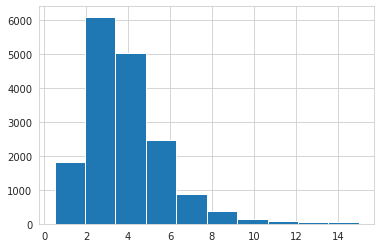

In [ ]:
# log transformation
# use log on 'median_income'

plt.hist(df['median_income'])

# Feature Selection

In [ ]:
# features = ['longitude', 'latitude', 'median_income']
# data = df[features]

# Dataset Normalization

In [ ]:
# Normalize data
data = StandardScaler().fit_transform(df)
data = pd.DataFrame(data)
data.columns = df.columns
print(len(data))
data.head(5)

17000


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,2.619365,-0.671520,-1.079671,1.361695,1.764204,-0.361184,-0.075998,-1.252543,-1.210558
1,2.539569,-0.573264,-0.761872,2.296608,3.230441,-0.261865,-0.099404,-1.081483,-1.096745
2,2.494683,-0.905463,-0.920772,-0.882462,-0.866956,-0.955354,-0.999252,-1.170105,-1.048461
3,2.489696,-0.928857,-1.159121,-0.524186,-0.480230,-0.796793,-0.715774,-0.362600,-1.154514
4,2.489696,-0.961609,-0.682422,-0.545747,-0.506328,-0.701830,-0.622148,-1.026454,-1.222629


# Dimensionality Reduction
The graph displays 2 plots: 1) The variance percentage of the individual components and 2) the cumulative sum of the variance percentage after applying PCA to the normalized dataset.

The goal is to choose n principal components such that n is less than the number of features, while keeping most of the dataset variance.

We can automatically choose n by setting a threshold on how much variance we want to keep in our dataset. For instance, if we want to keep 99% of the dataset variance, then we must use 6 principal components (~98.66% variance).

In [ ]:
X = data
x_axis = range(1, n_features+1)

# Apply PCA starting from 1 to n features
pca = PCA(n_components=None).fit(X)

# Get component variance
exp_var = pca.explained_variance_ratio_ * 100

# Calculate cumulative sum for components
cum_exp_var = np.cumsum(exp_var)

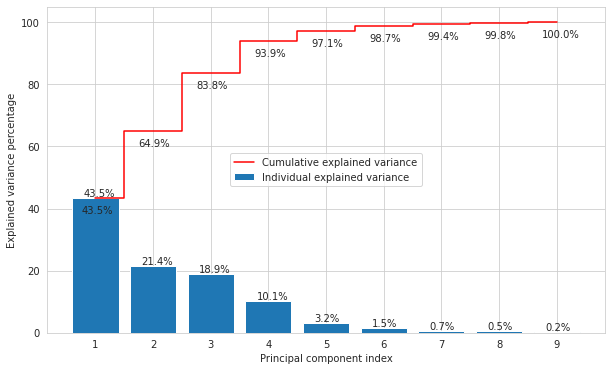

In [ ]:
plt.figure(figsize=(10,6))
bars = plt.bar(x_axis, exp_var, align='center', label='Individual explained variance')
steps = plt.step(x_axis, cum_exp_var, where='mid', label='Cumulative explained variance', color='red')

for bar in bars:
  x,width,height = bar.get_x(), bar.get_width(), bar.get_height()
  plt.text(x=x+width/4, y=height+0.50, s="{0}%".format(round(height,1)))

for x,y in steps[0].get_xydata():
  plt.text(x=x-0.25, y=y-5, s="{0}%".format(round(y,1)))

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=x_axis)
plt.legend(loc='center')
plt.show()

In [ ]:
VARIANCE_THRESHOLD = 65
n = np.where(cum_exp_var <= VARIANCE_THRESHOLD)[0][-1]
X = PCA(n_components=n+1).fit_transform(X)
print("{0} principal components with a cumulative variance of {1}%".format(n+1, cum_exp_var[n]))

2 principal components with a cumulative variance of 64.88130490694239%


# sklearn.cluster.KMeans
#### Params
- init: {'k-means++', 'random'} - Selects initial clusters the smart way or by random
- n-init: int, default=10 - Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
- max_iter: int, default=300 - Maximum number of iterations of the k-means algorithm for a single run.
- tol: float, default=1e-4 - Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.
  -  The Frobenius norm is matrix norm of an m×n matrix A defined as the square root of the sum of the absolute squares of its elements.
- random_state: int, RandomState instance or None, default=None - Add a random seed

In [ ]:
# Compute k-means
kmeans = [[i, KMeans(n_clusters=i, random_state=0).fit(X)] for i in range(2,10)]
# Retrieve k-means inertia
inertias = list(map(lambda kmean: [kmean[0], kmean[1].inertia_], kmeans))
inertias = pd.DataFrame(inertias)
inertias.columns = ('n_clusters', 'inertia')

In [ ]:
# Implement silhouette score to determine k for k-means

In [ ]:
cluster_labels = list(filter(lambda x: x[0]==6, kmeans))[0][1].predict(X)
data['econ_region'] = cluster_labels
data['econ_region'] = data['econ_region'].astype("category")
data.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,econ_region
0,2.619365,-0.671520,-1.079671,1.361695,1.764204,-0.361184,-0.075998,-1.252543,-1.210558,1
1,2.539569,-0.573264,-0.761872,2.296608,3.230441,-0.261865,-0.099404,-1.081483,-1.096745,1
2,2.494683,-0.905463,-0.920772,-0.882462,-0.866956,-0.955354,-0.999252,-1.170105,-1.048461,0
3,2.489696,-0.928857,-1.159121,-0.524186,-0.480230,-0.796793,-0.715774,-0.362600,-1.154514,0
4,2.489696,-0.961609,-0.682422,-0.545747,-0.506328,-0.701830,-0.622148,-1.026454,-1.222629,0


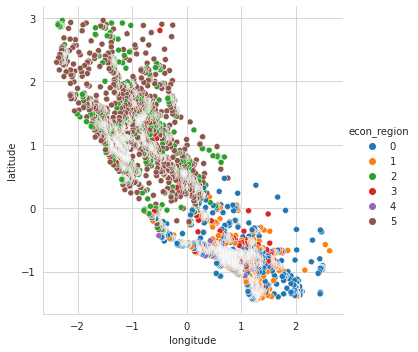

In [ ]:
sns.set_style('whitegrid')
sns.relplot(x='longitude', y='latitude', hue='econ_region', data=data, kind='scatter')
plt.show()

# Feature selection w/ Random Forest


---
## [Irrelavant for current project] Notes to implement a decision tree
### Measure Entropy
Entropy = $\sum(-p \cdot \log_2{(p_i)})$ \\
$p_i$ = probability of class $i$ \\
### Determine Information Gained (IG)
$IG_i = E(\text{parent}) - \sum(w_i \cdot E(\text{child}_i))$

Compare Information Gained of all class $i$ to determine which value has more IG.

*** $log_2$ for binary tree, or $log_n$ for n-tree